In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lichess-data-february-standard-rated-2025/lichess_db_standard_rated_2025-02.pgn.zst


In [29]:
!pip install zstandard python-chess

#### Getting Data
Decompressiing `.zst` compressed PGN (Portable Game Notation) file containing chess game, and read the first games from it.


In [30]:
import zstandard as zstd
import chess.pgn
import io

# Define input file path
input_path = "/kaggle/input/lichess-data-february-standard-rated-2025/lichess_db_standard_rated_2025-02.pgn.zst"

# Open the compressed file and stream decompress
with open(input_path, 'rb') as compressed_file:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(compressed_file) as reader:
        # Wrap decompressed stream with TextIOWrapper to behave like a file
        text_stream = io.TextIOWrapper(reader, encoding='utf-8')

        # Read the first game
        game = chess.pgn.read_game(text_stream)

        if game:
            print(game.headers)  # Print game metadata
        else:
            print("No games found in the PGN file!")


Headers(Event='Rated Blitz game', Site='https://lichess.org/sKojzYYV', Date='2025.02.01', Round='-', White='ferlionrod', Black='Tahafouad', Result='0-1', UTCDate='2025.02.01', UTCTime='00:00:00', WhiteElo='1671', BlackElo='1608', WhiteRatingDiff='-6', BlackRatingDiff='+6', ECO='A45', Opening='Paleface Attack', TimeControl='180+0', Termination='Normal')


### Creating Dataframe 

This code extracts and loads chess game data from a compressed PGN file into a Pandas DataFrame, including player names, game result, opening, and moves. The data is ready for **Exploratory Data Analysis (EDA)**, where you can analyze player performance, popular openings, and game outcomes. Visualizations and statistical analysis can further explore trends in game results and move sequences.


In [31]:
import pandas as pd

games_data = []
game_count = 0
max_games = 10000  # Change this to read more games

with open(input_path, 'rb') as compressed_file:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(compressed_file) as reader:
        text_stream = io.TextIOWrapper(reader, encoding='utf-8')

        while game_count < max_games:
            game = chess.pgn.read_game(text_stream)
            if game is None:
                break  # No more games

            games_data.append({
                "White": game.headers.get("White", ""),
                "Black": game.headers.get("Black", ""),
                "Result": game.headers.get("Result", ""),
                "ECO": game.headers.get("ECO", ""),
                "Opening": game.headers.get("Opening", ""),
                "Moves": " ".join(str(move) for move in game.mainline_moves())  # Convert moves to string
            })
            game_count += 1

print(f"Loaded {len(games_data)} games into DataFrame.")

# Convert to DataFrame and display
df = pd.DataFrame(games_data)



Loaded 10000 games into DataFrame.


## Inspecting Dataframe


In [32]:
df.head(100)


,White,Black,Result,ECO,Opening,Moves
0,ferlionrod,Tahafouad,0-1,A45,Paleface Attack,d2d4 g8f6 f2f3 d7d5 c2c4 c7c6 e2e3 g7g6 b1c3 f...
1,DJSale,Khallyx,0-1,D00,"Queen's Pawn Game: Accelerated London System, ...",d2d4 d7d5 c1f4 c7c5 e2e3 b8c6 g1f3 g8f6 f3e5 e...
2,Solrac77,JoaoZugzwang_81,1-0,B00,Pirc Defense,e2e4 d7d6 d2d4 g8f6 f1d3 c8g4 f2f3 g4c8 g1e2 b...
3,capapreta999,Capablanca13,0-1,C55,Italian Game: Two Knights Defense,e2e4 e7e5 g1f3 b8c6 f1c4 g8f6 e1g1 f8e7 d2d3 d...
4,MYakuzi,HTTP_403,0-1,B00,Fried Fox Defense,e2e4 f7f6 d2d4 e8f7 f1c4 e7e6 g1f3 a7a6 d4d5 b...
...,...,...,...,...,...,...
95,HGMS835,HGMS618,0-1,?,?,
96,HGMS509,HGMS834,1-0,A40,Queen's Pawn Game,d2d4
97,HGMS832,HGMS729,0-1,?,?,
98,HGMS513,HGMS768,1-0,B00,Duras Gambit,e2e4 f7f5 e4f5 c7c5 d1h5 g7g6 f5g6 h7g6 h5g6


In [33]:
df.tail(100)

,White,Black,Result,ECO,Opening,Moves
9900,forestdevs,ikprobeerhet13,1-0,D00,Queen's Pawn Game,e2e3 d7d5 d2d4 e7e5 d4e5 c8e6 g1f3 c7c6 c2c3 b...
9901,Jskend,KARA4421,1-0,C46,Three Knights Opening,e2e4 e7e5 g1f3 b8c6 b1c3 d7d6 f1b5 c8d7 h2h3 a...
9902,Corselpiantao,TurboGranny,1-0,C50,"Italian Game: Giuoco Pianissimo, Normal",e2e4 e7e5 g1f3 g8f6 f1c4 b8c6 d2d3 f8c5 e1g1 e...
9903,chesslooover,Muhammetjan,0-1,C00,French Defense: King's Indian Attack,e2e4 e7e6 d2d3 d7d5 b1d2 g8f6 g1f3 f8e7 g2g3 e...
9904,gavinashun,Zachwant,1-0,C00,French Defense: Knight Variation,e2e4 e7e6 g1f3 d7d5 e4d5 e6d5 d2d4 g8f6 f1b5 c...
...,...,...,...,...,...,...
9995,cologNell,IGNEA,0-1,A40,Horwitz Defense,d2d4 e7e6 g1f3 g8f6 b1c3 b8c6 c1f4 b7b6 c3b5 d...
9996,Zakirzyan,AkshaySingh,0-1,A01,Nimzo-Larsen Attack: English Variation,b2b3 c7c5 c1b2 e7e6 e2e3 d7d5 g1f3 b8c6 f1b5 g...
9997,isignal,Roddle,0-1,C50,Italian Game: Paris Defense,e2e4 e7e5 g1f3 d7d6 f1c4 b8c6 d2d3 c8g4 c4f7 e...
9998,AnnaAmari,cserick7,1-0,D00,Queen's Pawn Game: Accelerated London System,d2d4 d7d5 c1f4 e7e6 e2e3 g8f6 h2h3 c7c5 c2c3 b...


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   White    10000 non-null  object
 1   Black    10000 non-null  object
 2   Result   10000 non-null  object
 3   ECO      10000 non-null  object
 4   Opening  10000 non-null  object
 5   Moves    10000 non-null  object
dtypes: object(6)
memory usage: 468.9+ KB


### Data Cleaning Process

1. **Unknown Openings**:
   - Counts and prints the number of games with unknown openings (`"?"` in the "Opening" column).


In [35]:
unknown_openings_count = df[df["Opening"] == "?"].shape[0]
print(f"Games with unknown openings: {unknown_openings_count}")


Games with unknown openings: 58


2. **Short Move Games**:
   - Counts and prints the number of games with fewer than 12 moves.


In [36]:
short_move_games_count = df[df["Moves"].apply(lambda x: len(x.split()) < 12)].shape[0]
print(f"Games with less than 12 moves: {short_move_games_count}")


Games with less than 12 moves: 235


In [37]:
df_copy = df.copy()
len(df_copy)

10000


 **Data Cleaning**:
   - **Remove Unknown Openings**: Drops rows where the "Opening" column is `"?"`.
   - **Remove Short Games**: Drops games with fewer than 12 moves.


In [38]:
# Drop rows with unknown openings
df_clean = df_copy[df_copy["Opening"] != "?"]

# Drop games with less than 10 moves (e.g. weird games or aborted)
df_clean = df_clean[df_clean["Moves"].apply(lambda x: len(x.split()) >= 12)]

print(f"Remaining games after cleaning: {len(df_clean)}")


Remaining games after cleaning: 9765



3. **Result Conversion**:
   - Converts the game result into binary values: `1` for a White win, `1` for a Black win, and `0` for a draw.


In [39]:
def result_to_binary(result):
    if result == "1-0":
        return 1, 0
    elif result == "0-1":
        return 0, 1
    else:  # "1/2-1/2" or others
        return 0, 0

df_clean["White_Win"], df_clean["Black_Win"] = zip(*df_clean["Result"].map(result_to_binary))

# Quick check
print(df_clean[["Result", "White_Win", "Black_Win"]].head())


  Result  White_Win  Black_Win
0    0-1          0          1
1    0-1          0          1
2    1-0          1          0
3    0-1          0          1
4    0-1          0          1



5. **Final Data**:
   - The cleaned DataFrame is stored in `df_clean` with new columns for `White_Win` and `Black_Win`

In [40]:
df_clean.head()

,White,Black,Result,ECO,Opening,Moves,White_Win,Black_Win
0,ferlionrod,Tahafouad,0-1,A45,Paleface Attack,d2d4 g8f6 f2f3 d7d5 c2c4 c7c6 e2e3 g7g6 b1c3 f...,0,1
1,DJSale,Khallyx,0-1,D00,"Queen's Pawn Game: Accelerated London System, ...",d2d4 d7d5 c1f4 c7c5 e2e3 b8c6 g1f3 g8f6 f3e5 e...,0,1
2,Solrac77,JoaoZugzwang_81,1-0,B00,Pirc Defense,e2e4 d7d6 d2d4 g8f6 f1d3 c8g4 f2f3 g4c8 g1e2 b...,1,0
3,capapreta999,Capablanca13,0-1,C55,Italian Game: Two Knights Defense,e2e4 e7e5 g1f3 b8c6 f1c4 g8f6 e1g1 f8e7 d2d3 d...,0,1
4,MYakuzi,HTTP_403,0-1,B00,Fried Fox Defense,e2e4 f7f6 d2d4 e8f7 f1c4 e7e6 g1f3 a7a6 d4d5 b...,0,1


#### The `split_moves` function splits a sequence of chess moves into separate lists for White and Black, based on even and odd indices.


In [41]:
def split_moves(moves_sequence):
    """Splits a sequence of chess moves into separate lists for White and Black."""
    moves = moves_sequence.split()  # Split by spaces
    white_moves = moves[0::2]  # Even indices (White's moves)
    black_moves = moves[1::2]  # Odd indices (Black's moves)
    return white_moves, black_moves




In [42]:

# Apply function to split moves
df_clean["White Moves"], df_clean["Black Moves"] = zip(*df_clean["Moves"].apply(split_moves))

# Display the transformed data
print(df_clean)

             White            Black Result  ECO  \
0       ferlionrod        Tahafouad    0-1  A45   
1           DJSale          Khallyx    0-1  D00   
2         Solrac77  JoaoZugzwang_81    1-0  B00   
3     capapreta999     Capablanca13    0-1  C55   
4          MYakuzi         HTTP_403    0-1  B00   
...            ...              ...    ...  ...   
9995     cologNell            IGNEA    0-1  A40   
9996     Zakirzyan      AkshaySingh    0-1  A01   
9997       isignal           Roddle    0-1  C50   
9998     AnnaAmari         cserick7    1-0  D00   
9999  yegeaElmasry          rufus_k    1-0  B22   

                                                Opening  \
0                                       Paleface Attack   
1     Queen's Pawn Game: Accelerated London System, ...   
2                                          Pirc Defense   
3                     Italian Game: Two Knights Defense   
4                                     Fried Fox Defense   
...                              

## Preparation for Tensors

In [43]:
df_clean["MoveList"] = df_clean.apply(lambda row: [mv for pair in zip(row["White Moves"], row["Black Moves"]) for mv in pair if mv], axis=1)
df_clean.drop("Moves",axis=1, inplace=True)


In [44]:
from sklearn.preprocessing import LabelEncoder
import torch

# Extract move sequences
all_move_seqs = df_clean["MoveList"].tolist()

# Flatten to get full move vocabulary
all_moves = [move for seq in all_move_seqs for move in seq]

# Encode moves
encoder = LabelEncoder()
encoder.fit(all_moves)

# Transform move sequences
encoded_seqs = [encoder.transform(seq) for seq in all_move_seqs]

# Sliding window dataset
seq_len = 10  # First 10 to predict the 11th
X, y = [], []
for seq in encoded_seqs:
    if len(seq) <= seq_len:
        continue
    for i in range(seq_len, len(seq)):
        X.append(seq[i - seq_len:i])
        y.append(seq[i])


# Creating a tensor from a list of numpy.ndarrays is extremely slow
X_np = np.array(X)
y_np = np.array(y)

# Final tensors
X_tensor = torch.tensor(X_np, dtype=torch.long)
y_tensor = torch.tensor(y_np, dtype=torch.long)


In [45]:
print("X shape:", X_tensor.shape)
print("y shape:", y_tensor.shape)

print("X dtype:", X_tensor.dtype)
print("y dtype:", y_tensor.dtype)


X shape: torch.Size([562598, 10])
y shape: torch.Size([562598])
X dtype: torch.int64
y dtype: torch.int64


Print first few samples

In [46]:
print("First input sequence (token IDs):", X_tensor[0])
print("First target move (token ID):", y_tensor[0])


First input sequence (token IDs): tensor([ 720, 1648, 1232,  890,  467,  634,  977, 1629,  213, 1432])
First target move (token ID): tensor(1197)


If we want to decode back to UCI move for sanity Check

In [47]:
decoded_input = encoder.inverse_transform(X_tensor[0].numpy())
decoded_target = encoder.inverse_transform([y_tensor[0].item()])

print("Decoded input:", decoded_input)
print("Decoded target:", decoded_target[0])


Decoded input: ['d2d4' 'g8f6' 'f2f3' 'd7d5' 'c2c4' 'c7c6' 'e2e3' 'g7g6' 'b1c3' 'f8g7']
Decoded target: f1d3


Value Ranges

In [48]:
print("Min token ID:", X_tensor.min().item())
print("Max token ID:", X_tensor.max().item())
print("Vocabulary size:", len(encoder.classes_))  # Total unique moves


Min token ID: 0
Max token ID: 1861
Vocabulary size: 1862


### Distribution of Targets and Labels

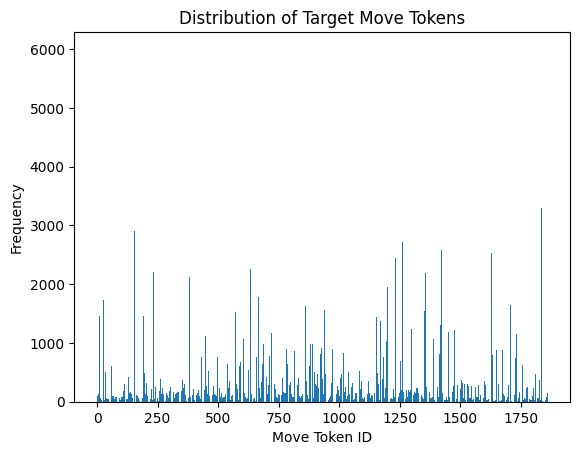

In [49]:
import matplotlib.pyplot as plt

unique, counts = torch.unique(y_tensor, return_counts=True)
plt.bar(unique.numpy(), counts.numpy())
plt.title("Distribution of Target Move Tokens")
plt.xlabel("Move Token ID")
plt.ylabel("Frequency")
plt.show()


### Building our first Model

In [50]:
import torch.nn as nn

class MoveRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256):
        super(MoveRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        # x: [batch_size, seq_len]
        x = self.embedding(x)           # -> [batch, seq_len, embed_dim]
        output, _ = self.lstm(x)        # -> [batch, seq_len, hidden_dim]
        last_hidden = output[:, -1, :]  # -> [batch, hidden_dim]
        return self.fc(last_hidden)     # -> [batch, vocab_size]


### Training Loop

In [51]:
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

# Prepare DataLoader
batch_size = 64
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model init
vocab_size = len(encoder.classes_)
model = MoveRNN(vocab_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        output = model(X_batch)              # [batch, vocab_size]
        loss = criterion(output, y_batch)    # classification loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")


Epoch 1/10, Loss: 49045.9276
Epoch 2/10, Loss: 42733.6444
Epoch 3/10, Loss: 39896.4108
Epoch 4/10, Loss: 38006.0765
Epoch 5/10, Loss: 36604.2678
Epoch 6/10, Loss: 35478.8243
Epoch 7/10, Loss: 34565.1532
Epoch 8/10, Loss: 33795.7685
Epoch 9/10, Loss: 33158.8813
Epoch 10/10, Loss: 32596.8464


 ### Quick Evaluation after Training

In [52]:
model.eval()
with torch.no_grad():
    sample_input = X_tensor[0].unsqueeze(0).to(device)  # [1, 10]
    prediction = model(sample_input)                    # [1, vocab_size]
    predicted_index = prediction.argmax(dim=1).item()
    predicted_move = encoder.inverse_transform([predicted_index])[0]

    print("Input Moves:", encoder.inverse_transform(X_tensor[0].numpy()))
    print("Target Move:", encoder.inverse_transform([y_tensor[0].item()])[0])
    print("Predicted Move:", predicted_move)


Input Moves: ['d2d4' 'g8f6' 'f2f3' 'd7d5' 'c2c4' 'c7c6' 'e2e3' 'g7g6' 'b1c3' 'f8g7']
Target Move: f1d3
Predicted Move: g1f3


So our model predicts moves. However these moves are not legal moves. Hence we need to 

In [55]:
import chess

# Reconstruct board from input moves
input_moves = encoder.inverse_transform(X_tensor[0].numpy())
board = chess.Board()
for move in input_moves:
    try:
        board.push_san(move)
    except:
        print(f"Illegal move in input: {move}")
        break

# Get all legal UCI moves
legal_uci = [move.uci() for move in board.legal_moves]
legal_tokens = encoder.transform([m for m in legal_uci if m in encoder.classes_])

# Mask prediction output
with torch.no_grad():
    sample_input = X_tensor[0].unsqueeze(0).to(device)
    logits = model(sample_input)[0]  # [vocab_size]
    logits_filtered = logits[legal_tokens]
    top_index = legal_tokens[logits_filtered.argmax().item()]
    predicted_move = encoder.inverse_transform([top_index])[0]

    print("Input Moves:", encoder.inverse_transform(X_tensor[0].numpy()))
    print("Target Move:", encoder.inverse_transform([y_tensor[0].item()])[0])
    print("Predicted Move:", predicted_move)


Input Moves: ['d2d4' 'g8f6' 'f2f3' 'd7d5' 'c2c4' 'c7c6' 'e2e3' 'g7g6' 'b1c3' 'f8g7']
Target Move: f1d3
Predicted Move: g1e2
